[Twitter](https://x.com/dec1costello) | [GitHub](https://github.com/dec1costello) | [Kaggle](https://www.kaggle.com/dec1costello) | [LinkedIn](https://www.linkedin.com/in/declan-costello-7423aa137/)

<div class="alert alert-block alert-info">
    <b> Key Principles </b><br>
- This notebook will walk through some fun use cases and viz for Strokes Gained Stats 
    
</div>

## **Table of Context**
1. [Installation](#Installation)
2. [Importing Data](#Importing-Data)
3. [Probability Density](#Probability-Density)
4. [SG by Distance](#SG-by-Distance)
5. [SG by Lie](#SG-by-Lie)
6. [Course Factors](#Course-Factors)
7. [xS Map](#xS-Map)
8. [SG Percentile](#SG-Percentile)
9. [SG by Shot Type](#SG-by-Shot-Type)

# 📚 **Installation**

In [1]:
import bz2
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import norm
import matplotlib.pyplot as plt

from bokeh.layouts import column
from bokeh.plotting import figure, show
from bokeh.palettes import viridis, cividis
from bokeh.transform import factor_cmap, jitter, dodge
from bokeh.io import show, export_svgs, output_file, output_notebook
from bokeh.models import FixedTicker, ColumnDataSource, Whisker, FactorRange

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module='category_encoders.base_contrast_encoder')

# Create viridis palette
viridis_palette = viridis(256)

# 📂 **Data**

In [2]:
result_df = pd.read_csv("SG.csv")

# **📊 Probability Density**

In [3]:
# Set the parameters of the normal distribution
mean, std = 0, 1  # You can adjust these parameters based on your desired shape

# Generate synthetic data from the normal distribution
resid_scores = result_df['SG_True']

# Fit the normal distribution to the synthetic data
params = norm.fit(resid_scores)

# Now you can use the parameters for further analysis or generating random samples

# Calculate histogram
hist, edges = np.histogram(resid_scores, density=True, bins=60)

# Generate the x values for the fitted normal distribution
x = np.linspace(min(resid_scores), max(resid_scores), 100)

# Calculate the probability density function for the fitted normal distribution
pdf = norm.pdf(x, *params)

# Create a Bokeh figure
p = figure(height=450, width=600,title=f'Residual Normality \n\nMean: {params[0]:.2f}, Std Dev: {params[1]:.2f}', 
           x_axis_label='Residual Scores', y_axis_label='Density')

# Plot the histogram
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color='white', 
       fill_color=viridis_palette[180], alpha=0.9)

# Plot the fitted normal distribution
p.line(x, pdf, line_color=viridis_palette[10], line_width=4, legend_label='Fitted Normal Distribution')
p.x_range.start = -1
p.x_range.end = 1
p.y_range.start = 0

In [4]:
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '200+']

# Apply binning to the DataFrame
result_df['SG_by_distance'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False)

# Fill missing values with empty string
result_df['SG_by_distance'] = result_df['SG_by_distance'].cat.add_categories([''])
result_df['SG_by_distance'] = result_df['SG_by_distance'].fillna('')

SG_by_distance_series = result_df.groupby(['last_name', 'SG_by_distance'], observed=False)['SG_True'].sum()

SG_by_distance_df = SG_by_distance_series.to_frame().reset_index()
pivoted_df = SG_by_distance_df.pivot(index='last_name', columns='SG_by_distance', values='SG_True')

new_columns = []
for col in pivoted_df.columns:
    try:
        col_int = int(col)
        new_col_name = f'{col_int - 50}-{col_int + 50}_SG_by_distance'
    except ValueError:
        new_col_name = col  # If conversion fails, keep the original name
    new_columns.append(new_col_name)

pivoted_df.columns = new_columns

# Resetting index to make last_name a column
pivoted_df.reset_index(inplace=True)
pivoted_df.drop(pivoted_df.columns[-1], axis=1, inplace=True)
pivoted_df.rename(columns={'last_name': 'Golfer'}, inplace=True)
new_order = ['Golfer', '200+','150-200','100-150','50-100', '0-50']
pivoted_df = pivoted_df[new_order]

places = {'Haas': 1,
        'Mahan': 2,
        'Donald': 3, 
        'Choi': 3, 
        'Baddeley': 3,
        'Howell III': 6, 
        'Scott': 6, 
        'Day': 6, 
        'Van Pelt': 9, 
        'Mickelson': 10, 
        'Ogilvy': 11, 
        'Bradley': 11, #
        'Woodland': 13, 
        'Dufner': 13, 
        'Stricker': 15, 
        'Singh': 16, 
        'Toms': 16, 
        'Snedeker': 16, 
        'Jacobson': 16, 
        'Rose': 20, 
        'Kuchar': 20, 
        'Simpson': 22, 
        'Johnson': 23, 
        'Watson': 23, 
        'Senden': 25, 
        'Wilson': 26, 
        'Reavie': 26, 
        'Watney': 26, 
        'Yang': 29, 
        'Byrd': 30}

pivoted_df['Finish'] = pivoted_df['Golfer'].map(places)
pivoted_df = pivoted_df.sort_values(by='Finish', ascending=True)

# **True SG by Distance**

In [5]:
cm = sns.light_palette("lightblue", as_cmap=True)
pivoted_df.style.hide(axis='index').set_caption("True SG by Distance").background_gradient(subset=["50-100","100-150","200+","150-200", "0-50"],cmap=cm)

Golfer,200+,150-200,100-150,50-100,0-50,Finish
Haas,2.798652,-0.358221,5.233171,-0.941147,0.894962,1
Mahan,4.301016,1.778685,-1.215931,0.286057,1.764627,2
Donald,-4.060368,4.093387,2.459360,-0.660585,2.832660,3
Baddeley,0.925894,0.573501,4.183071,1.883758,-1.120342,3
Choi,-2.337259,5.878484,0.814994,-0.156973,0.465206,3
Day,-0.373198,2.528208,-0.707189,0.050977,1.297429,6
Howell III,4.956898,-1.390601,0.235443,0.369143,-0.344233,6
Scott,2.058628,2.914694,2.460166,-0.627620,-2.289563,6
Van Pelt,1.016490,0.204639,0.467021,0.081374,0.854930,9
Mickelson,0.926597,1.367432,0.885720,-0.660178,-0.855117,10


In [6]:
from_location_scorer_df_series = result_df.groupby(['last_name','from_location_scorer'])['SG_True'].sum()
SG_by_lie_df = from_location_scorer_df_series.to_frame().reset_index()
lies_df = SG_by_lie_df.pivot(index='last_name', columns='from_location_scorer', values='SG_True')
lies_df.columns = [f'{col}' for col in lies_df.columns]
# Filling NaN values with 0
lies_df.fillna(0, inplace=True)

# Resetting index to make last_name a column
lies_df.reset_index(inplace=True)

lies_df['Bunker'] = lies_df[['Green Side Bunker', 'Fairway Bunker']].sum(axis=1)
lies_df.drop(columns=['Green Side Bunker', 'Fairway Bunker'], inplace=True)

lies_df['Other'] = lies_df[['Bunker','Fringe','Other', 'Unknown','Native Area']].sum(axis=1)
lies_df.drop(columns=['Bunker', 'Fringe','Native Area','Unknown'], inplace=True)

lies_df['Rough'] = lies_df[['Intermediate Rough', 'Primary Rough']].sum(axis=1)
lies_df.drop(columns=['Intermediate Rough', 'Primary Rough'], inplace=True)

lies_df.rename(columns={'last_name': 'Golfer'}, inplace=True)

new_order = ['Golfer', 'Tee Box','Rough','Fairway','Green', 'Other']
lies_df = lies_df[new_order]

lies_df['Finish'] = lies_df['Golfer'].map(places)
lies_df = lies_df.sort_values(by='Finish', ascending=True)


# **SG by Lie**

In [7]:
cm_rough = sns.light_palette("darkgreen", as_cmap=True)
cm_tee = sns.light_palette("lightblue", as_cmap=True)
cm_sand = sns.light_palette("yellow", as_cmap=True)
cm_fair = sns.light_palette("green", as_cmap=True)
cm_green = sns.light_palette("lightgreen", as_cmap=True)

lies_df.style.hide(axis='index').set_caption("True SG by Lie").background_gradient(subset=["Other"],cmap=cm_sand).background_gradient(subset=["Rough"],cmap=cm_rough).background_gradient(subset=["Tee Box"],cmap=cm_tee).background_gradient(subset=["Fairway"],cmap=cm_fair).background_gradient(subset=["Green"],cmap=cm_green)

Golfer,Tee Box,Rough,Fairway,Green,Other,Finish
Haas,1.838606,-1.627132,5.782870,-0.501402,2.134475,1
Mahan,2.633515,2.967121,0.809552,-0.818272,1.322538,2
Donald,-4.423864,2.905708,3.258279,-0.089944,3.014275,3
Baddeley,0.672589,1.461807,6.095529,-2.189606,0.405565,3
Choi,-2.667919,3.764202,3.082537,-0.880084,1.365718,3
Day,-0.119003,-1.055357,2.540814,-1.815845,3.245619,6
Howell III,3.711163,-1.536203,4.016837,-1.642032,-0.723115,6
Scott,1.345630,0.597450,2.957709,-2.376802,1.992318,6
Van Pelt,0.188061,-0.937126,3.553840,-0.906254,0.725933,9
Mickelson,0.455568,4.076111,-2.867346,-1.056118,1.056238,10


# **Course Factors**

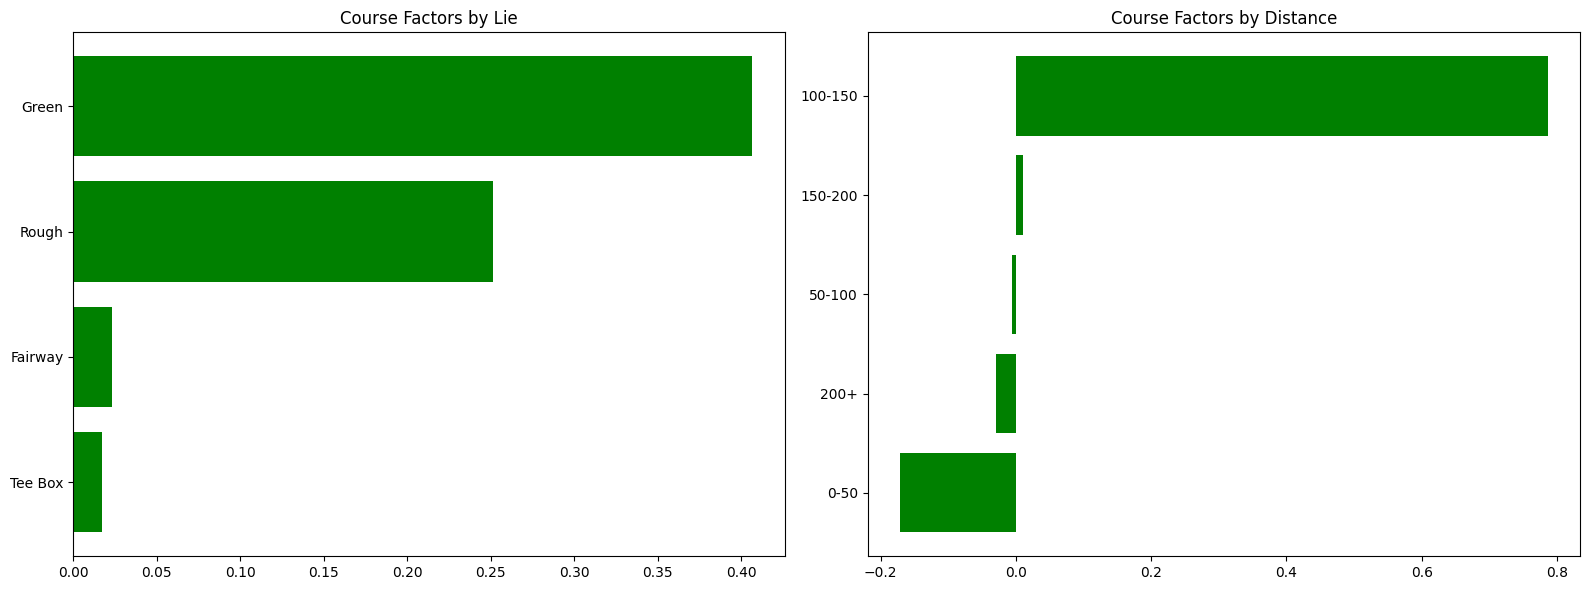

In [8]:
# --- Model 1: Lie Factors ---
numerical_cols_lie = ["Tee Box", "Rough", "Fairway", "Green"]
feature_cols_lie = numerical_cols_lie

X_lie = lies_df[feature_cols_lie]
y_lie = lies_df['Finish']

# Split data
X_train_lie, X_test_lie, y_train_lie, y_test_lie = train_test_split(X_lie, y_lie, test_size=0.2, random_state=88)

# Scale data
scaler_lie = StandardScaler()
X_train_scaled_lie = scaler_lie.fit_transform(X_train_lie)
X_test_scaled_lie = scaler_lie.transform(X_test_lie)

# Train XGBoost model
model_lie = XGBRegressor(objective='reg:squarederror', random_state=88, n_estimators=88)
model_lie.fit(X_train_scaled_lie, y_train_lie)

# Compute permutation importance
importance_lie = permutation_importance(model_lie, X_test_scaled_lie, y_test_lie, n_repeats=88, random_state=88)
sorted_idx_lie = np.argsort(importance_lie.importances_mean)[::-1][:10]

# --- Model 2: Distance Factors ---
numerical_cols_dist = ["200+", "150-200", "100-150", "50-100", "0-50"]
feature_cols_dist = numerical_cols_dist

X_dist = pivoted_df[feature_cols_dist]
y_dist = pivoted_df['Finish']

# Split data
X_train_dist, X_test_dist, y_train_dist, y_test_dist = train_test_split(X_dist, y_dist, test_size=0.2, random_state=88)

# Scale data
scaler_dist = StandardScaler()
X_train_scaled_dist = scaler_dist.fit_transform(X_train_dist)
X_test_scaled_dist = scaler_dist.transform(X_test_dist)

# Train XGBoost model
model_dist = XGBRegressor(objective='reg:squarederror', random_state=88, n_estimators=88)
model_dist.fit(X_train_scaled_dist, y_train_dist)

# Compute permutation importance
importance_dist = permutation_importance(model_dist, X_test_scaled_dist, y_test_dist, n_repeats=88, random_state=88)
sorted_idx_dist = np.argsort(importance_dist.importances_mean)[::-1][:10]

# --- Plotting both ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot feature importance by Lie
axs[0].barh(np.array(feature_cols_lie)[sorted_idx_lie], importance_lie.importances_mean[sorted_idx_lie], color = 'green')
axs[0].set_title("Course Factors by Lie")
axs[0].invert_yaxis()

# Plot feature importance by Distance
axs[1].barh(np.array(feature_cols_dist)[sorted_idx_dist], importance_dist.importances_mean[sorted_idx_dist], color = 'green')
axs[1].set_title("Course Factors by Distance")
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()


# **xS Map**

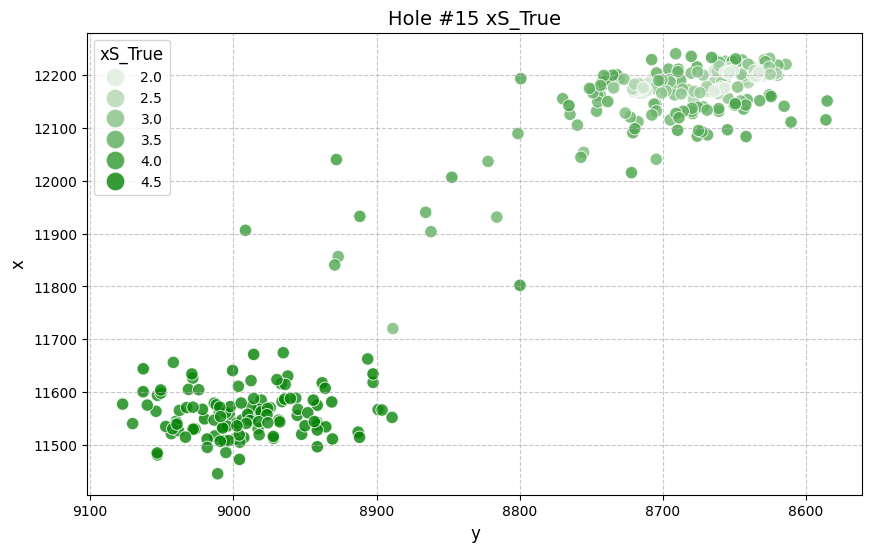

In [9]:
cm = sns.light_palette("green", as_cmap=True)

# Filter DataFrame
temp_df = result_df[result_df['hole'] == 15]

temp_df = temp_df[temp_df['x'] != 0]
temp_df = temp_df[temp_df['y'] != 0]
temp_df = temp_df[temp_df['to_location_scorer'] != 'Unknown']

# Create the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='y', y='x', alpha=0.8, hue='xS_True', data=temp_df, palette=cm, s=80, edgecolor='w')

# Customize the plot
legend = ax.legend(fontsize='10', loc='upper left', title='xS_True', title_fontsize='12', markerscale=1.5)
ax.invert_xaxis()
ax.set_title('Hole #15 xS_True', fontsize=14)
ax.set_xlabel('y', fontsize=12)
ax.set_ylabel('x', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# **True SG Percentile by Shot Type**

In [10]:
output_notebook()

bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['50-0', '100-50', '150-100', '200-150', '200+']

# Apply binning
result_df['SG_bins'] = pd.cut(result_df['distance_to_pin'], bins=bins, labels=labels, right=False).cat.add_categories(['', 'Putting', 'OTT']).fillna('')
result_df.loc[result_df['from_location_scorer'] == 'Green', 'SG_bins'] = 'Putting'
result_df.loc[result_df['from_location_scorer'] == 'Tee Box', 'SG_bins'] = 'OTT'

# Compute percentiles relative to the entire field
result_df['sg_binned_percentile'] = result_df.groupby(['par_value', 'SG_bins', 'round'], observed=True)['SG_True'].rank(pct=True)

df = result_df[result_df['last_name'] == 'Bradley']
order = ['OTT', '200+', '200-150', '150-100', '100-50', '50-0', 'Putting']
df['SG_bins'] = pd.Categorical(df['SG_bins'], categories=order, ordered=True)

sg_bins_mapping = {label: i for i, label in enumerate(order)}
df['SG_bins_numeric'] = df['SG_bins'].map(sg_bins_mapping)

# Updated colormap usage
winter_palette = plt.get_cmap('winter', 8)
def index_to_color(index):
    return tuple(int(c * 255) for c in winter_palette(index / 255)[:3])

colors = {cat: index_to_color(i * 40) for i, cat in enumerate(order)}
palette = [colors[cat] for cat in order]

# Define plot
p2 = figure(height=400, width=700, title=f"Bradley's True SG Percentile by Shot Type")
p2.xaxis.axis_label, p2.yaxis.axis_label = 'Shot Type', 'SG Percentile'
p2.xaxis.major_label_text_font_size = p2.yaxis.axis_label_text_font_size = '12pt'
p2.title.text_font_size = '18pt'
p2.xgrid.grid_line_color = None
p2.xaxis.ticker = FixedTicker(ticks=list(sg_bins_mapping.values()))
p2.xaxis.major_label_overrides = {i: label for label, i in sg_bins_mapping.items()}

# Compute whisker data
g = df.groupby("SG_bins", observed=True)
whisker_data = g['sg_binned_percentile'].quantile([0.25, 0.75]).unstack().reset_index()
whisker_data['base'] = whisker_data['SG_bins'].map(sg_bins_mapping)
source = ColumnDataSource(whisker_data.rename(columns={0.75: 'upper', 0.25: 'lower'}))

# Add whiskers
p2.add_layout(Whisker(base="base", upper="upper", lower="lower", source=source, level="annotation", line_width=2))

# Add scatter plot
p2.scatter(jitter("SG_bins_numeric", 0.3, range=p2.x_range), "sg_binned_percentile", source=df, alpha=0.3, size=15, 
           line_color="white", color=factor_cmap("SG_bins", palette=palette, factors=order))

# Show the plot
show(p2)

Loading BokehJS ...

In [11]:
# Group and sum 'SG_True' while setting observed=False to avoid FutureWarning
df_grouped = df.groupby(['SG_by_distance', 'from_location_scorer'], observed=False)['SG_True'].sum().reset_index()

# Remove 'Green' and 'Tee Box'
df_filtered = df_grouped[~df_grouped['from_location_scorer'].isin(['Green', 'Tee Box'])]

# Define new categories while using include_groups=False in apply() to avoid DeprecationWarning
df_transformed = df_filtered.groupby('SG_by_distance', observed=False).apply(
    lambda group: pd.Series({
        'Fairway': group.loc[group['from_location_scorer'] == 'Fairway', 'SG_True'].sum(),
        'Other': group.loc[group['from_location_scorer'] != 'Fairway', 'SG_True'].sum()
    }), include_groups=False
).reset_index()

# Drop the last row
df_transformed.drop(df_transformed.tail(1).index, inplace=True)

# Compute values for 'Tee Box' and 'Green' separately
tee_box_sg = df.groupby('from_location_scorer', observed=False)['SG_True'].sum().get('Tee Box', 0)
green_sg = df.groupby('from_location_scorer', observed=False)['SG_True'].sum().get('Green', 0)

# Create DataFrames for 'Tee Box' and 'Green'
TB_row = pd.DataFrame({'SG_by_distance': ["Tee Box"], 'OTT': [tee_box_sg]})
g_row = pd.DataFrame({'SG_by_distance': ["Green"], 'Putting': [green_sg]})

df_transformed = pd.concat([df_transformed, g_row, TB_row], ignore_index=True)

df_transformed['SG_by_distance'] = df_transformed['SG_by_distance'].astype(str)
data_dict_v2 = {
    'SG_by_distance': df_transformed['SG_by_distance'].tolist(),
    'Fairway': df_transformed['Fairway'].tolist(),
    'Other': df_transformed['Other'].tolist(),
}


# Convert DataFrame to dictionary for Bokeh
df_transformed['SG_by_distance'] = df_transformed['SG_by_distance'].astype(str)
data_dict_v2 = {
    'SG_by_distance': df_transformed['SG_by_distance'].tolist(),
    'Fairway': df_transformed['Fairway'].tolist(),
    'Other': df_transformed['Other'].tolist(),
    'Putting': df_transformed['Putting'].tolist(),
    'OTT': df_transformed['OTT'].tolist(),

}

# Create ColumnDataSource
source = ColumnDataSource(data=data_dict_v2)

# Define x-axis categories
categories = df_transformed['SG_by_distance'].tolist()

# Custom color scheme (green-themed)
custom_colors = ['purple','lightblue','blue','lightgreen']

# Create figure
p = figure(x_range=FactorRange(*categories), height=500, width=700, 
           title="Bradley's SG by Shot Type and Distance",
           toolbar_location=None, tools="", output_backend="svg")

p.vbar(x=dodge('SG_by_distance', 0.15, range=p.x_range), top='Putting', source=source,
       width=0.3, color=custom_colors[3], legend_label="Putting")

# Add grouped bars using dodge
p.vbar(x=dodge('SG_by_distance', -0.15, range=p.x_range), top='Fairway', source=source,
       width=0.3, color=custom_colors[1], legend_label="Fairway")

p.vbar(x=dodge('SG_by_distance', 0.15, range=p.x_range), top='Other', source=source,
       width=0.3, color=custom_colors[2], legend_label="Other")


p.vbar(x=dodge('SG_by_distance', 0.15, range=p.x_range), top='OTT', source=source,
       width=0.3, color=custom_colors[0], legend_label="OTT")

# Adjust axis and styling
p.x_range.factors = ['Green','0-50', '50-100', '100-150', '150-200', '200+', 'Tee Box']
p.y_range.start = df_transformed[['Fairway', 'Other','Putting','OTT']].values.min() - 1
p.y_range.end = df_transformed[['Fairway', 'Other','Putting','OTT']].values.max() + 1
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None

p.xaxis.axis_label = 'Shot Distance'
p.yaxis.axis_label = 'Strokes Gained'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'
p.title.text_font_size = '18pt'
p.legend.title = "Shot Type"
p.legend.label_text_font_size = '10pt'
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

# Show the plot
show(p)
